In [0]:
import os
import unicodedata
import string
import random
from __future__ import unicode_literals, print_function, division
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [0]:
if not os.path.exists('data'):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip 
    !sudo rm -r data.zip

In [0]:
class generate_dataset(Dataset):
    
    def __init__(self,root_dir):
        self.letters = string.ascii_letters + " .,;'"

        self.names_categorized = {}
        self.languages = []

        for filename in os.listdir(root_dir):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.languages.append(category)
            self.names_categorized[category] = self.read_lines(os.path.join('data/names',filename))

    def unicode_to_ascii(self,s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.letters
        )

    def read_lines(self,filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicode_to_ascii(line) for line in lines]

    # Turn a letter into a 1 hot encoded vector
    def letter_to_tensor(self,letter):
        tensor = torch.zeros(1, len(self.letters))
        tensor[0,self.letters.find(letter)] = 1
        return tensor

    # Turn a line into a [line_length x 1 x n_letters], an array of one-hot letter vectors
    def line_to_tensor(self,line):
        tensor = torch.zeros(len(line), 1, len(self.letters))
        for i, letter in enumerate(line):
            tensor[i][0][self.letters.find(letter)] = 1
        return tensor

    def tensor_to_language(self,tensor):
        return self.languages[tensor.argmax().item()]
    
    def len_letters(self):
        return len(self.letters)

    def len_languages(self):
        return len(self.languages)

    def categories(self):
        return self.languages
    
    def random_sample(self):  
        category = random.choice(self.languages)
        line = random.choice(self.names_categorized[category])

        category_tensor = torch.tensor([self.languages.index(category)], dtype=torch.long)
        line_tensor = self.line_to_tensor(line)
        return category, line, category_tensor, line_tensor

dataset = generate_dataset('data/names')

In [4]:
category, line, category_tensor, line_tensor = dataset.random_sample()
print(category, line)

French Macon


In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.hidden(combined)
        output = self.softmax(self.output(combined))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

num_letters = dataset.len_letters()
num_languages = dataset.len_languages()
rnn = RNN(num_letters, 128, num_languages)

####Run a single pass through rnn

In [6]:
category, line, category_tensor, line_tensor = dataset.random_sample()
output, next_hidden = rnn(line_tensor[0], rnn.init_hidden())
print(line, category, dataset.tensor_to_language(output))

Suh Korean German


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.0001)

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.train()
    global output
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward(retain_graph=True)
    optimizer.step()

    return output, loss.item()

def find_acc(pred, label):
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

In [8]:
n_iters = 1000000
print_every = 1000

# Keep track of losses for plotting
current_loss = 0
current_acc = 0
losses = []
accuracies = []

# Training Loop
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.random_sample()
    output, loss = train(category_tensor, line_tensor)
    acc = find_acc(output, category_tensor)
    current_loss += loss
    current_acc += acc


    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        pred_language = dataset.tensor_to_language(output)

        print('Iteration: %d   Loss: %.4f  Accuracy: %.4f %%' % (iter, current_loss/print_every, current_acc/print_every))
        losses.append(current_loss/print_every)
        accuracies.append((current_acc/100)/print_every)
        current_loss = 0
        current_acc = 0

Iteration: 1000   Loss: 2.8766  Accuracy: 12.3000 %
Iteration: 2000   Loss: 2.7810  Accuracy: 16.3000 %
Iteration: 3000   Loss: 2.6486  Accuracy: 20.9000 %
Iteration: 4000   Loss: 2.5771  Accuracy: 18.3000 %
Iteration: 5000   Loss: 2.4875  Accuracy: 19.8000 %
Iteration: 6000   Loss: 2.4521  Accuracy: 23.5000 %
Iteration: 7000   Loss: 2.4103  Accuracy: 26.2000 %
Iteration: 8000   Loss: 2.3533  Accuracy: 28.0000 %
Iteration: 9000   Loss: 2.3353  Accuracy: 27.5000 %
Iteration: 10000   Loss: 2.2867  Accuracy: 30.3000 %
Iteration: 11000   Loss: 2.2606  Accuracy: 29.9000 %
Iteration: 12000   Loss: 2.2299  Accuracy: 31.8000 %
Iteration: 13000   Loss: 2.1906  Accuracy: 34.7000 %
Iteration: 14000   Loss: 2.1663  Accuracy: 33.9000 %
Iteration: 15000   Loss: 2.1283  Accuracy: 36.1000 %
Iteration: 16000   Loss: 2.0993  Accuracy: 33.8000 %
Iteration: 17000   Loss: 2.0788  Accuracy: 35.2000 %
Iteration: 18000   Loss: 2.0419  Accuracy: 37.5000 %
Iteration: 19000   Loss: 2.0450  Accuracy: 36.9000 %
It

In [9]:
for name, param in rnn.named_parameters():
    print('Name: {}      Shape: {}'.format(name, param.shape))

Name: hidden.weight      Shape: torch.Size([128, 185])
Name: hidden.bias      Shape: torch.Size([128])
Name: output.weight      Shape: torch.Size([18, 185])
Name: output.bias      Shape: torch.Size([18])


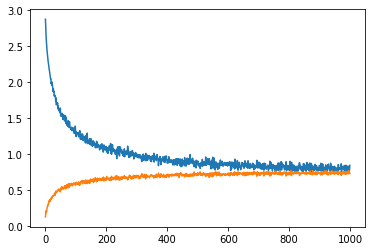

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses)
plt.plot(accuracies)

##Draw Confusion Matrix

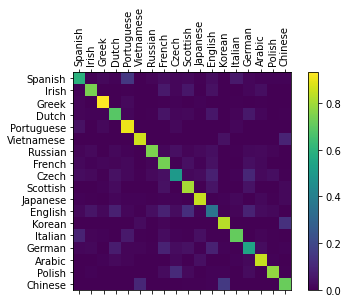

In [11]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(num_languages, num_languages)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    global output
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = dataset.random_sample()
    output = evaluate(line_tensor)
    guess = dataset.tensor_to_language(output)
    guess_index = dataset.categories().index(guess)
    category_index = dataset.categories().index(category)
    confusion[category_index][guess_index] += 1

# Normalize by dividing every row by its sum
for i in range(num_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + dataset.categories(), rotation=90)
ax.set_yticklabels([''] + dataset.categories())

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

##Predict on custom names

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(dataset.line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)

        for i in range(n_predictions):
            prob = math.exp(topv[0][i].item())
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (prob, dataset.categories()[category_index]))

predict('Nassir')


> Nassir
(0.95) Arabic
(0.02) Czech
(0.01) English
